In [1]:
from utils.visual import print_table, plot_train_val, plot_accuaracy
import pandas as pd
import os
import pandas as pd
%config InlineBackend.figure_format = 'retina'


# Проверка результатов статьи [Training BatchNorm and Only BatchNorm: On the Expressive Power of Random Features in CNNs](https://arxiv.org/pdf/2003.00152.pdf)

### Введение
Статья написана в 2020 году лабораторией фейсбука. Авторы задались вопросом, а что будет если тренировать только линейный слой в Batch Norm, а все остальные веса инициализировать случайными значениями и больше не трогать. Результаты оказались интересными, исследователи добились в 83% на датасете CIFAR10. 

### Основные тезисы
- Для экспериментов использовались [ResNet](https://arxiv.org/pdf/1512.03385.pdf) разработанные для датасет CIFAR10.
- Использовались различные архитекутры ResNet - менялась глубина сети при фиксированной ширине, а также менялась ширина при фиксированной глубине. 
- Тренировали несколько конфигураций - BN, BN + линейный выход, BN + линейный выход + skip connection, линейный выход + skip connection
- За baseline принимался результат полностью обученной сети >90% точность и не обученной ~10%.

### Выводы

- Максимальная точность при тренировки только BN - 83%. Этот результат показала сеть глубиной 866 слоев.
- При тренировки только BN - при увеличении глубины или ширины точность возрастает. Но при увеличении глубины возрастает быстрее.
- Тренировка линейного выхода и skip connection лучше работает на широких, но не глубоких сетях. 
- В случае тренировки только BN - 27% всех γ (y = x*γ + β) меньше 0.01. То есть BN отключает больше четверти всех функций. В случае тренировки всех слоев только 9% γ меньше 0.01.



### План работы
В этой статье меня заинтересовал эксперимент с тренировкой только BN слоев и интрепретацией γ как выключателя ненужных фичей. Мне кажется, что подход использования тренировки только BN можно использовать как 


### Реализация результатов статьи

### Архитектура сетей
В статье используются архитектуры ResNet с разной глубиной и шириной. Названия строятся по следующему шаблону name_N[_W]. 
N - Общее количество слоев, влияет на глубину
W - Множитель для количества весов (если не указан, то 1), влияет на ширину. 

Такие архитектуры должны получится:

<img src="img/table.png"  width="500" height="600">


Проверим правильность реализованных архитектур 

In [2]:
deep_nets = ["cifar_resnet_14", 
             "cifar_resnet_32", 
             "cifar_resnet_56", 
             "cifar_resnet_110",
             "cifar_resnet_218",]

wide_nets = ["cifar_resnet_14_1", 
             "cifar_resnet_14_2", 
             "cifar_resnet_14_4", 
             "cifar_resnet_14_8",]

# 434, 866, 14_16, 14_32 не используются, в данном эксперименте 

# Объявим имена архитектур с замороженными весами кроме весов BN
deep_freeze_nets = list(map(lambda x: x.replace("resnet", "freeze"), deep_nets))
wide_freeze_nets = list(map(lambda x: x.replace("resnet", "freeze"), wide_nets))

models = [*deep_nets, *wide_nets]
freeze_models = [*deep_freeze_nets, *wide_freeze_nets]
all_models = [*models, *freeze_models]

print_table(all_models)

                           BatchNorm          Shortcut            Output             Total         Trainable
   cifar_resnet_14              1120              2752               650            175258            175258
   cifar_resnet_32              2464              2752               650            466906            466906
   cifar_resnet_56              4256              2752               650            855770            855770
  cifar_resnet_110              8288              2752               650           1730714           1730714
  cifar_resnet_218             16352              2752               650           3480602           3480602
 cifar_resnet_14_1              1120              2752               650            175258            175258
 cifar_resnet_14_2              2240             10624              1290            696618            696618
 cifar_resnet_14_4              4480             41728              2570           2777674           2777674
 cifar_resnet_14_8 

Функция print_table вычисляет количество параметров в слоях с соответствующим паттерном. Реализованные сети похожи на сети из статьи как минимум количеством параметров :)

Стоит обратить внимание на столбец Trainable - он содержит количество параметров, которую могут изменяться в процессе тренировки. Для обычных сетей этот параметр совпадает с общим количеством параметров, а для freeze сетей, он совпадает с количеством параметров BN.

### Точность различных конфигураций

Для визуализации результатов были взяты два бейзлайна - точность архитектуры со случайной инициализацией весов (~ 10%) и точность при обучении всех слоев (>90%). Для сравнения вероятность случайно выбрать 1 клас из 10 равновероятных - 10%, а точность человека на CIFAR10 [~94%](https://arxiv.org/pdf/1811.07270.pdf). На представленном ниже графике для нас важны зеленая, синия и красные линии. Красная соответствует точности определенной архитектуры с тренируемыми весами только при BN. Красная рамка выделяет рассматриваемые мной архитектуры.

<img src="img/all.png"  width="1000" height="600">

Проверим эти результаты на реализованных архитектурах из прошлого шага.

Гиперпараметры для обучения используемые в статье: 
- 160 эпох 
- инициализация весов - He Normal
- оптимизиатор SGD с моментом 0.9
- размер батча 128
- learning rate 0.1
- уменьшение learning rate в 10 раз на эпохах 80 и 120
- рандомные флипы по горизонтали
- рандомные кропы максимум на 4 пикселив любую сторону
- нормализация данных


Нарисуем график используя сохраненные результаты

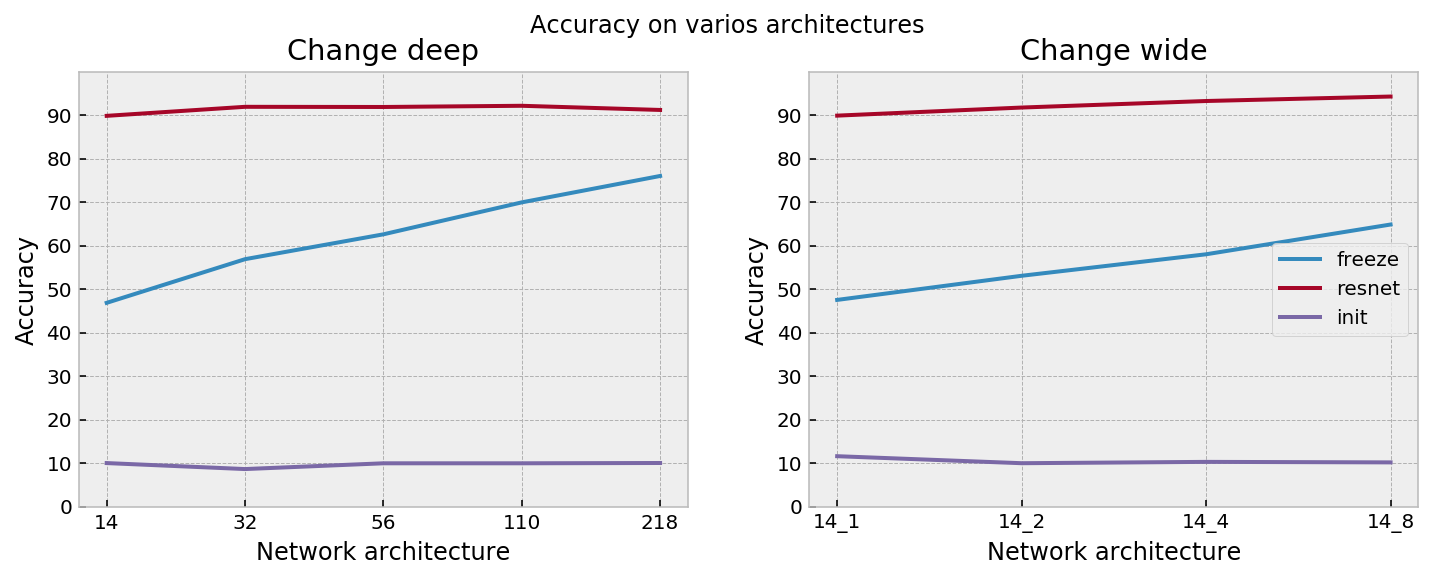

In [3]:
# Добавим результаты с случайно инициализрованными весами
init_deep_nets = list(map(lambda x: x.replace("resnet", "init"), deep_nets))
init_wide_nets = list(map(lambda x: x.replace("resnet", "init"), wide_nets))
all_models.extend(init_deep_nets)
all_models.extend(init_wide_nets)
# Загрузим 
path_to_accuracy = "predictions/save_results"
accuracy = []
for name in all_models:
    with open(os.path.join(path_to_accuracy, name + "_metric.txt"), "r") as f:
        accuracy.append(float(f.read()))

plot_accuaracy(all_models, accuracy)

Результаты получились похожие на те, что в статье. Незначительные различия могут быть вызваны тем, что в оригинале результат достигался средним по 5 прогонам - с разными инициализациями, порядком данных и аугментаций. Выведу изображение еще раз для визуальног сравнения.
<img src="img/all.png"  width="1000" height="600">

Отсюда можно сделать вывод, что реализованная архитектура и условия тренировки близки к тем что использовали авторы. Также можно подтвердить основой вывод статьи, что при тренировки только слоев BN можно получить достаточно высокий результат.

Лучший результат получился на самой глубокой архитектуре ResNet_218, полученная точность - 76.028%. 

Результат на основной сети, которую рассматривали авторы ResNet_110  69.7% мой 69.96%. 

Также подтвердился вывод о том, что точность растет вместе с глубиной слоев, а также с увеличением ширины. Но при увеличении глубины рост сильнее. Лучший полученный результат на "широких" сетях показала сеть resnet_14_8 64.86%.

### Процесс обучения

Посмотрим на процесс тренировки сети Resnet-110, 

In [8]:
path = "Weight/runs/"
all_models = [*models, *freeze_models]

# Загрузим точность и ошибку для всех моделей
model_metric = []
model_loss = []
for name in all_models:
    cur_path = os.path.join(path, os.path.join(name, name))
    metric_path = cur_path + "_metric.csv"
    loss_path = cur_path + "_loss.csv"
    model_metric.append(pd.read_csv(metric_path, names=["train", "val"]))
    model_loss.append(pd.read_csv(loss_path, names=["train", "val"]))


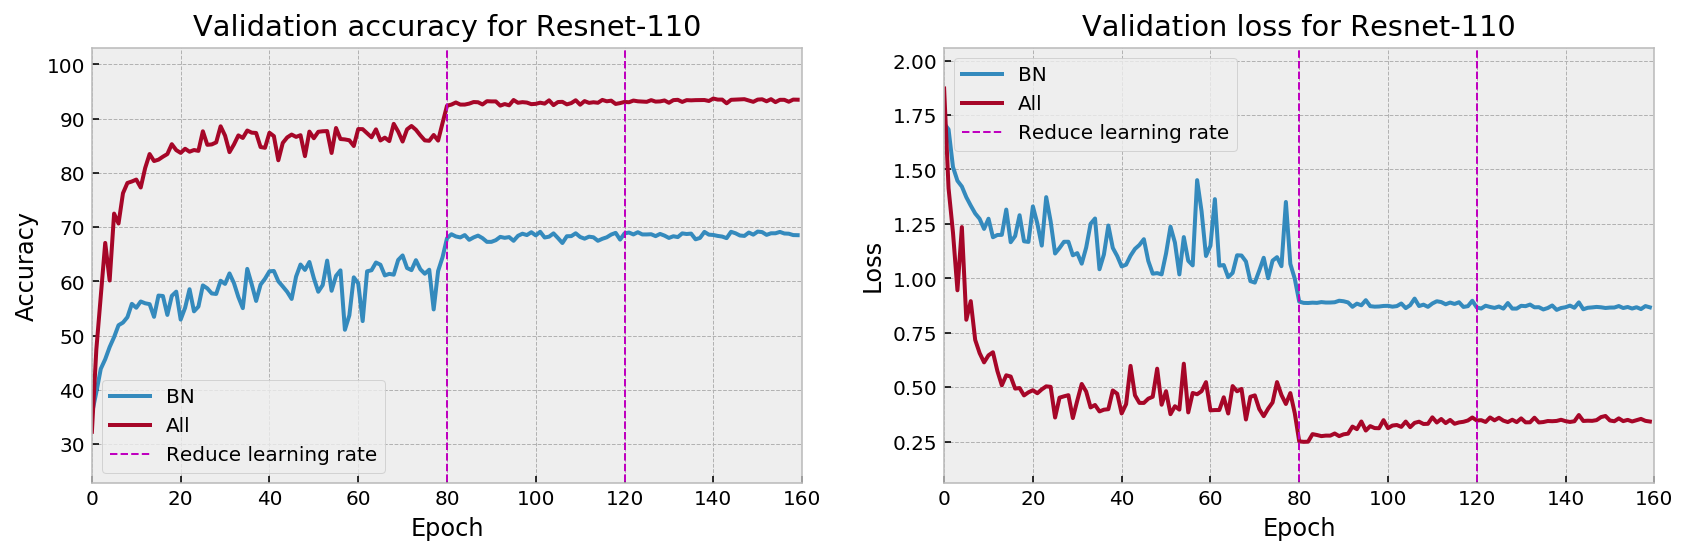

In [9]:
# Определим значения для сети cifar_resnet_110
index_110 = all_models.index("cifar_resnet_110")
metric_110 = model_metric[index_110]
loss_110 = model_loss[index_110]
# А также ее параметры при замороженных весах
index_fr_110 = all_models.index("cifar_freeze_110")
metric_fr_110 = model_metric[index_fr_110]
loss_fr_110 = model_loss[index_fr_110]

val_loss_110_vs_110_fr = pd.concat([metric_110["val"], metric_fr_110["val"]], axis=1)
val_metric_110_vs_110_fr = pd.concat([loss_110["val"], loss_fr_110["val"]], axis=1)
# Нарисуем график
plot_train_val("Resnet-110", val_loss_110_vs_110_fr, val_metric_110_vs_110_fr, title="Validation", label1="BN", label2="All")

Результат описанный в статье:

<img src="img/resnet110.png"  width="600" height="600">

Как и в статье, полученные модели сходятся к локальному минимуму и перестают увеличивать точность после ~82  шага. Уменьшение learning rate в первый раз дает значительный прирост к точности. 

### Переобучение

Рассмотрим train val кривые для всех обученных сеток. 

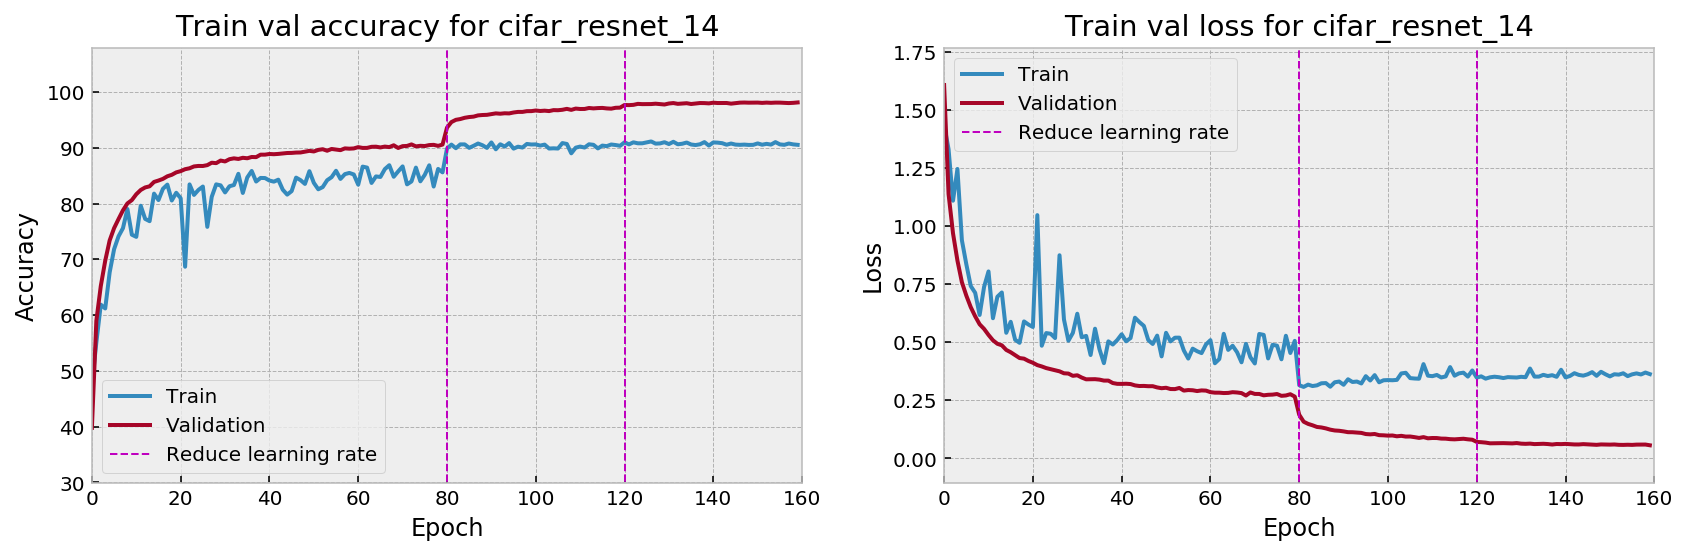

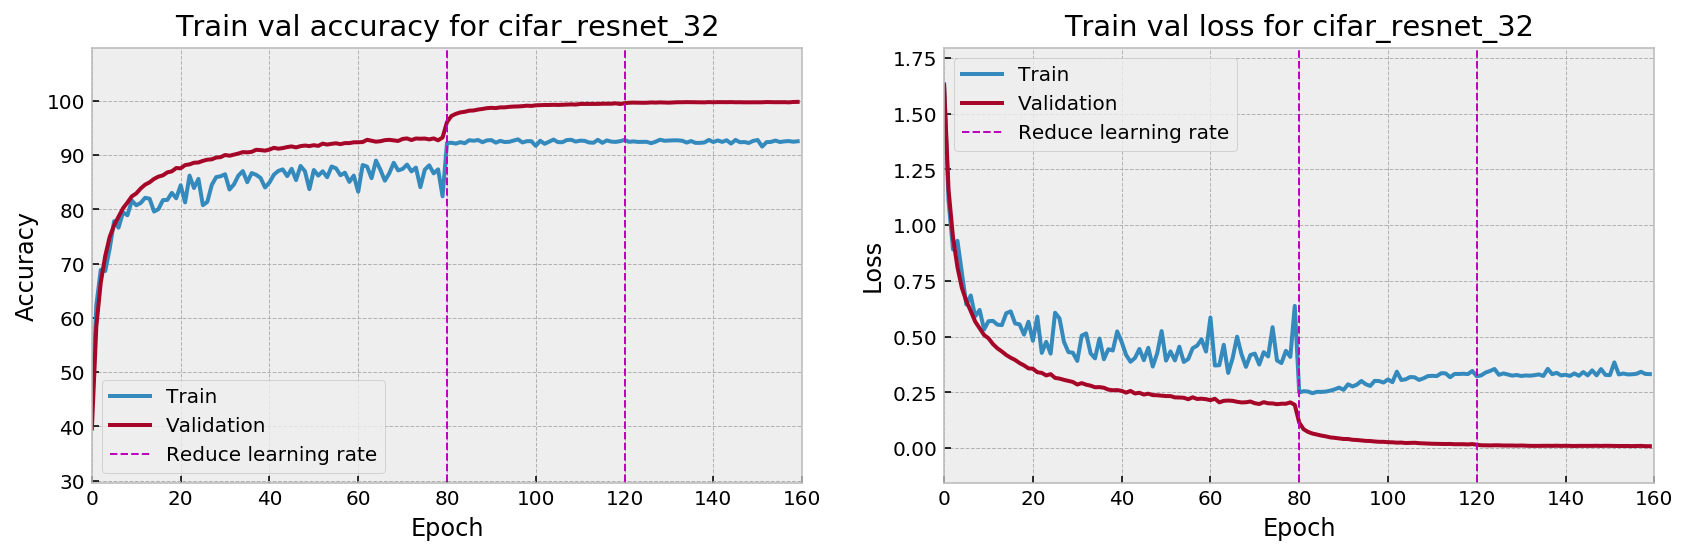

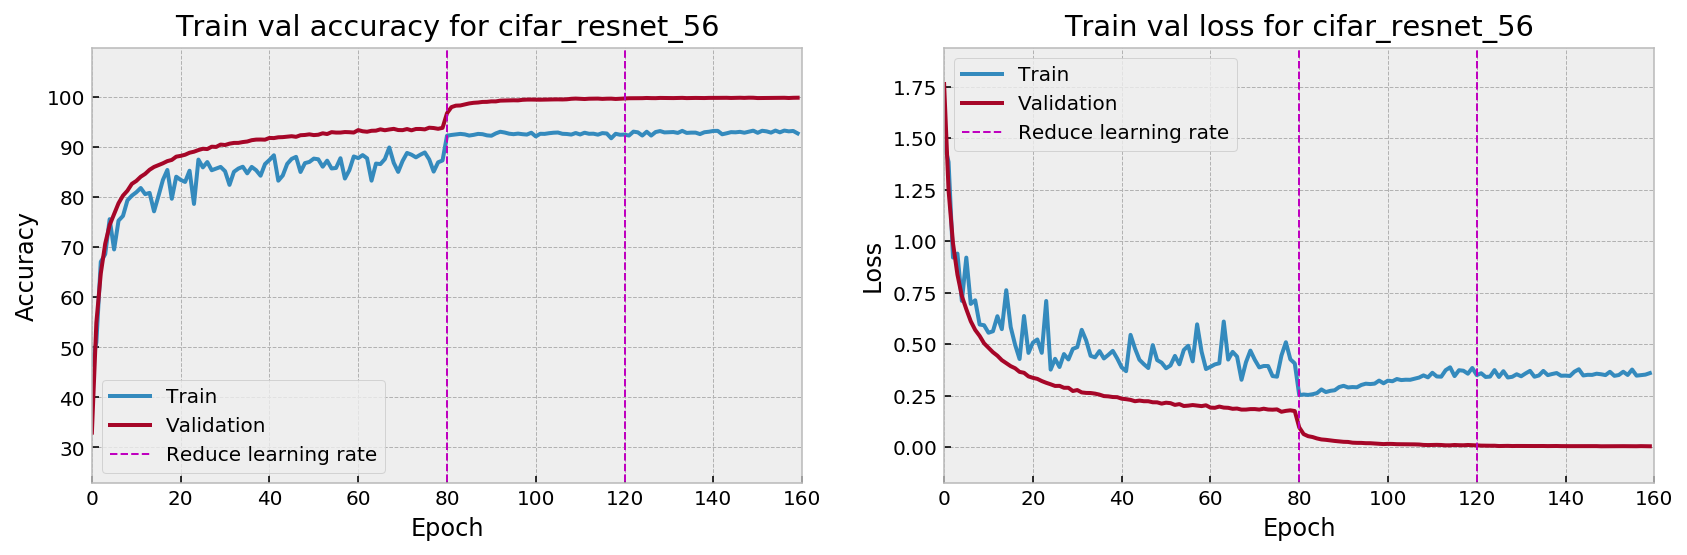

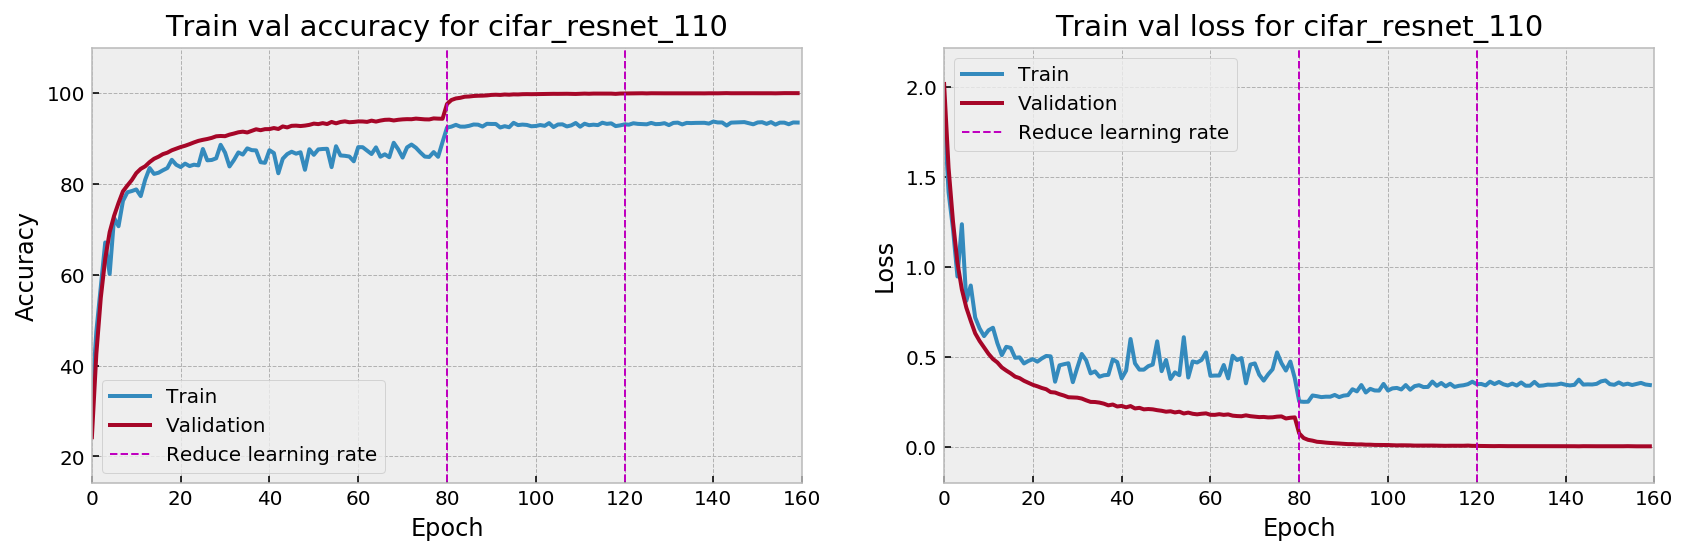

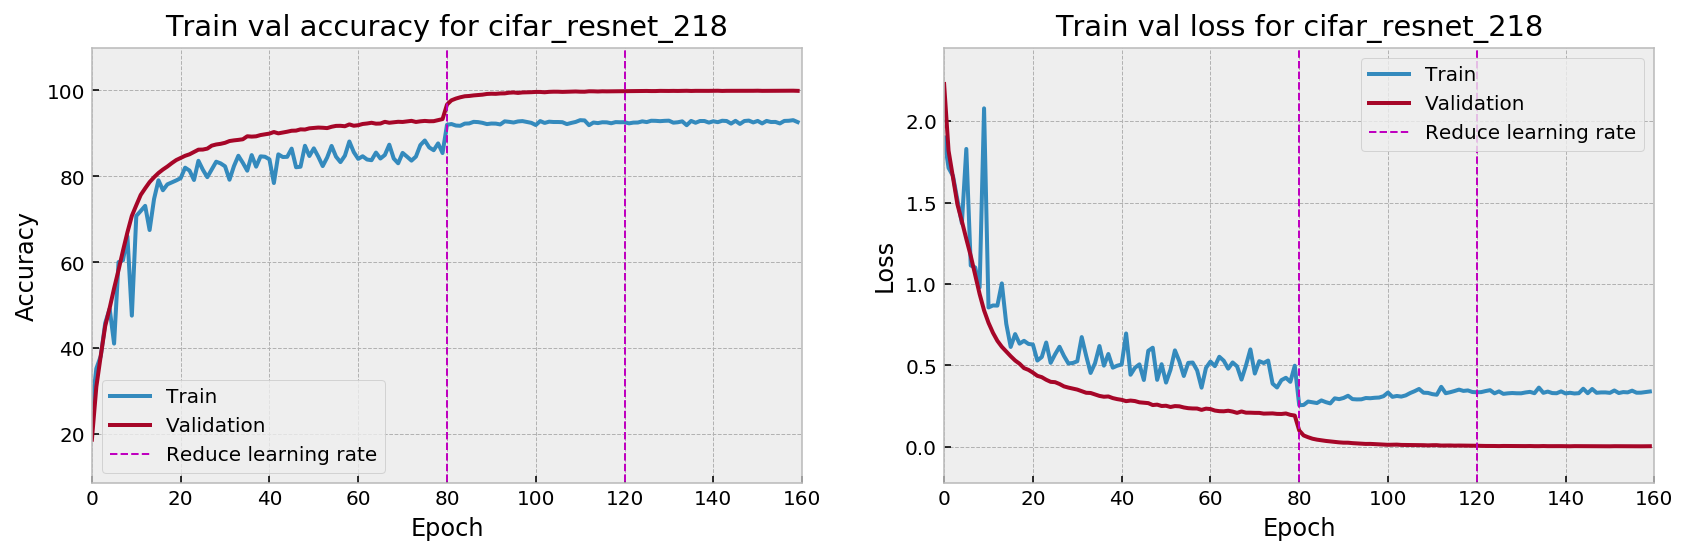

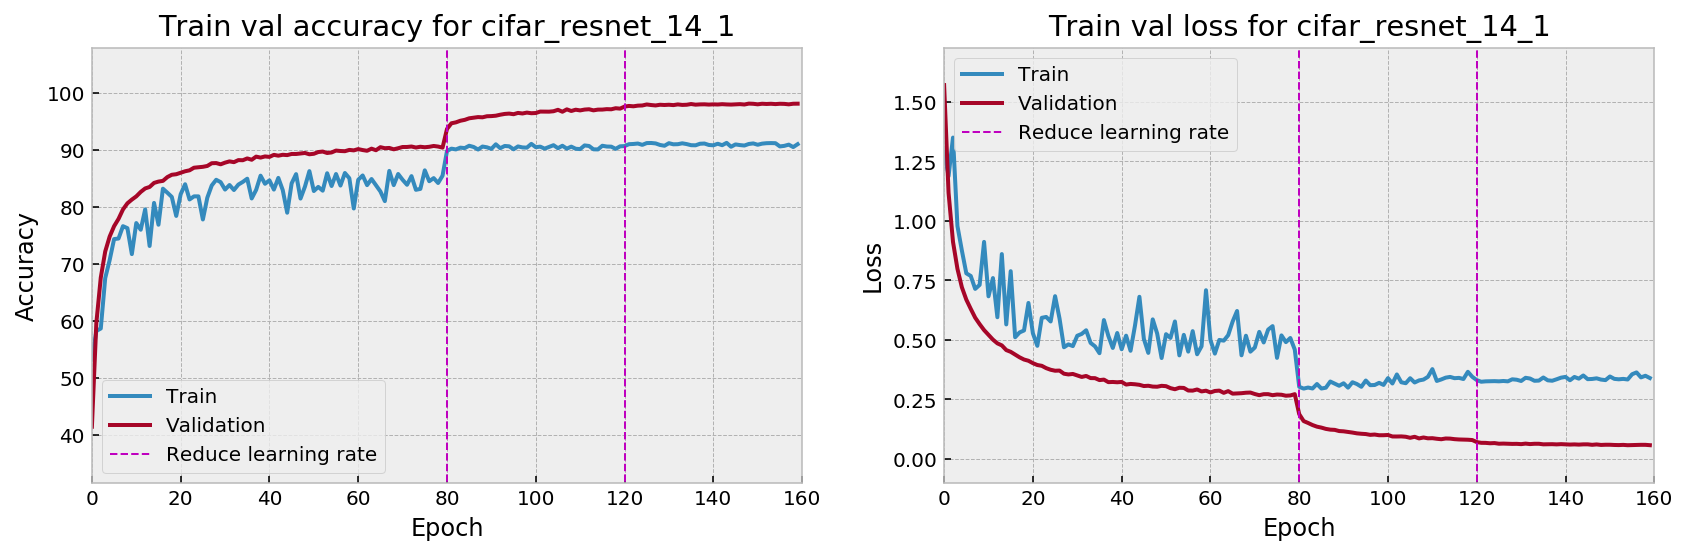

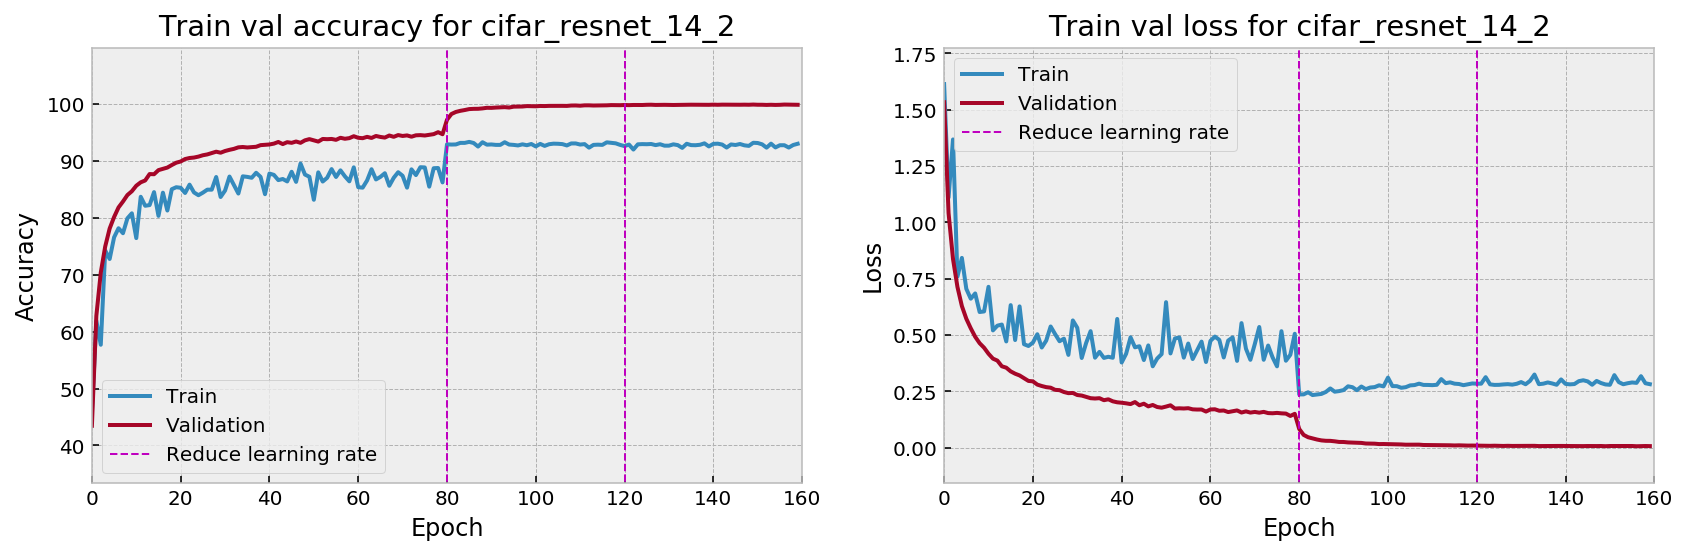

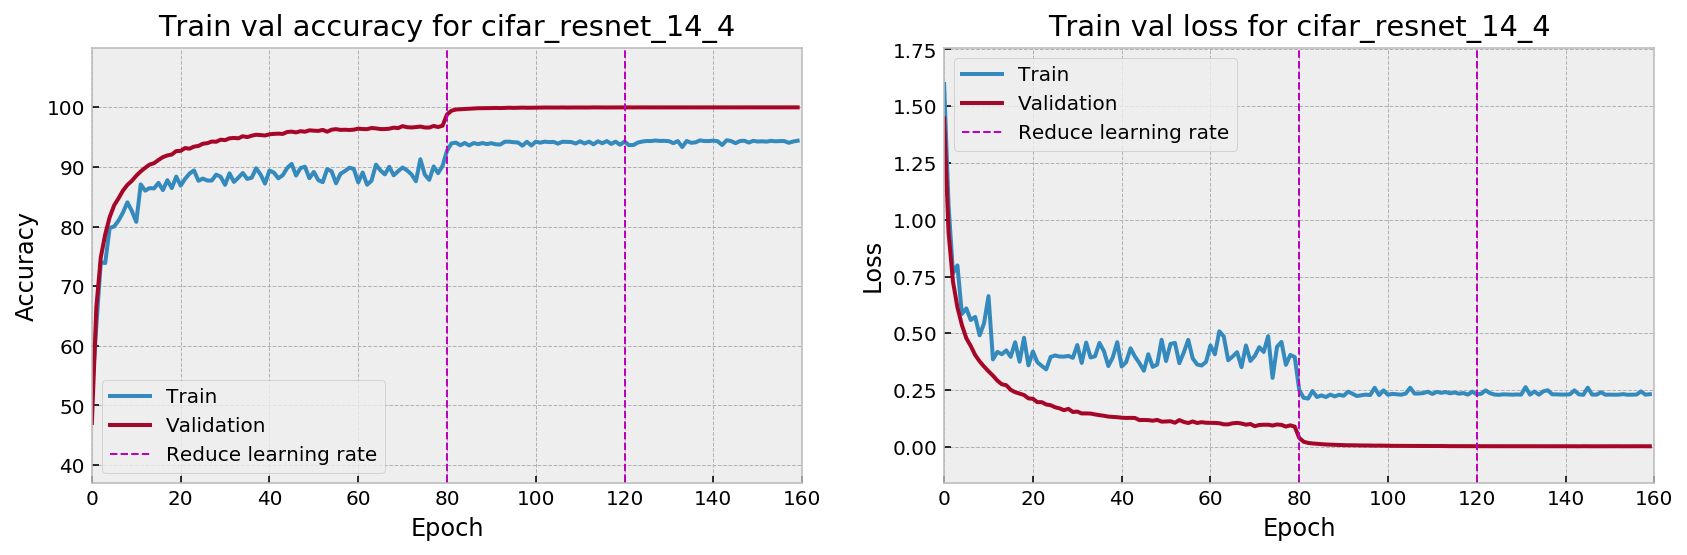

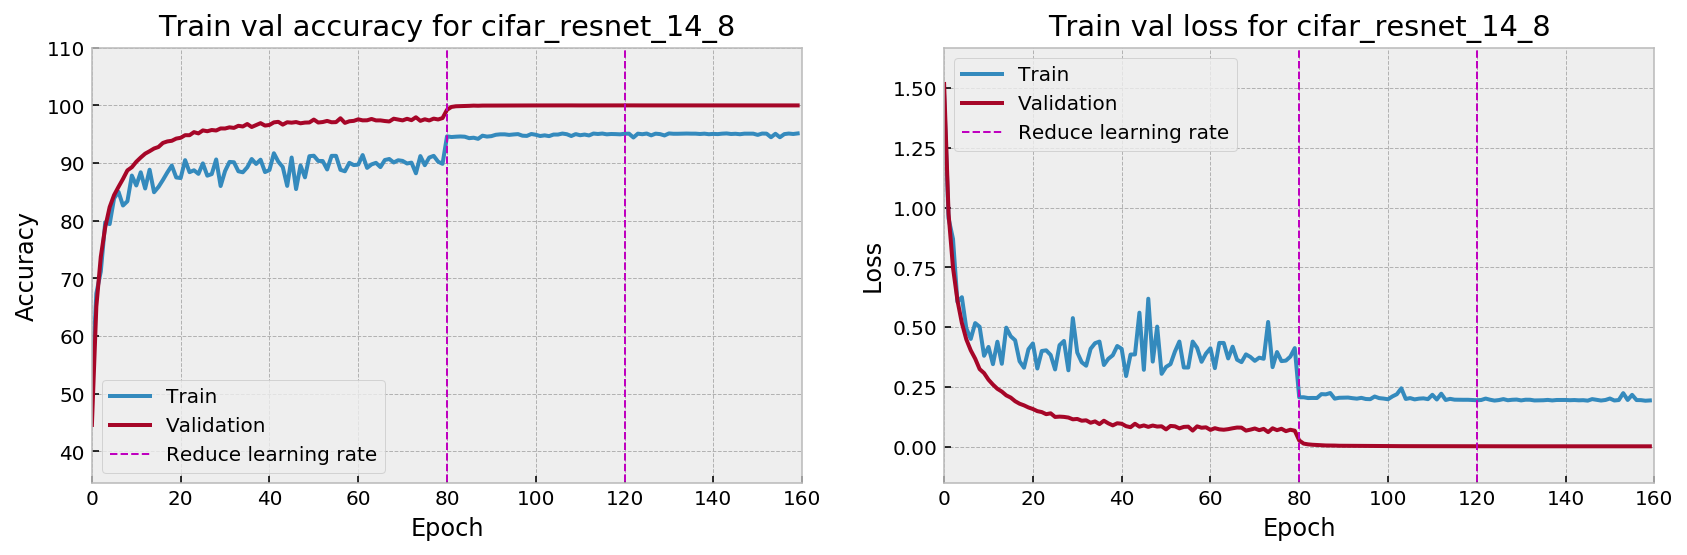

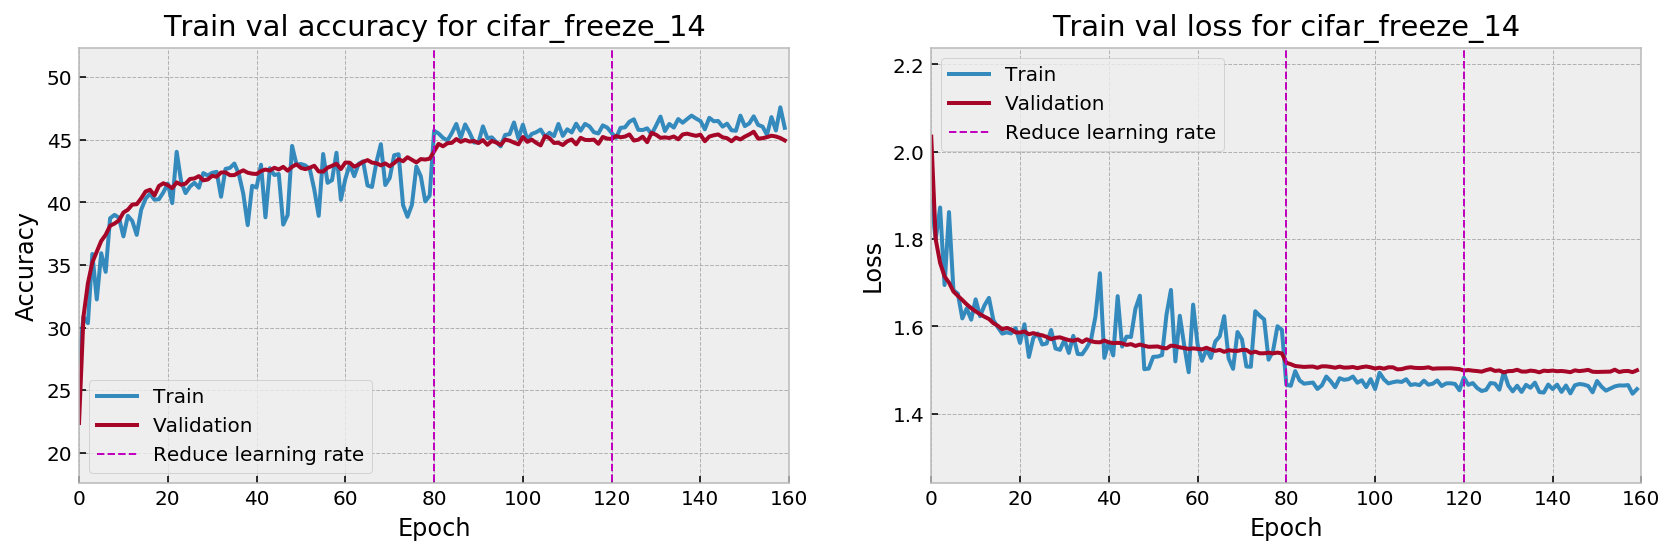

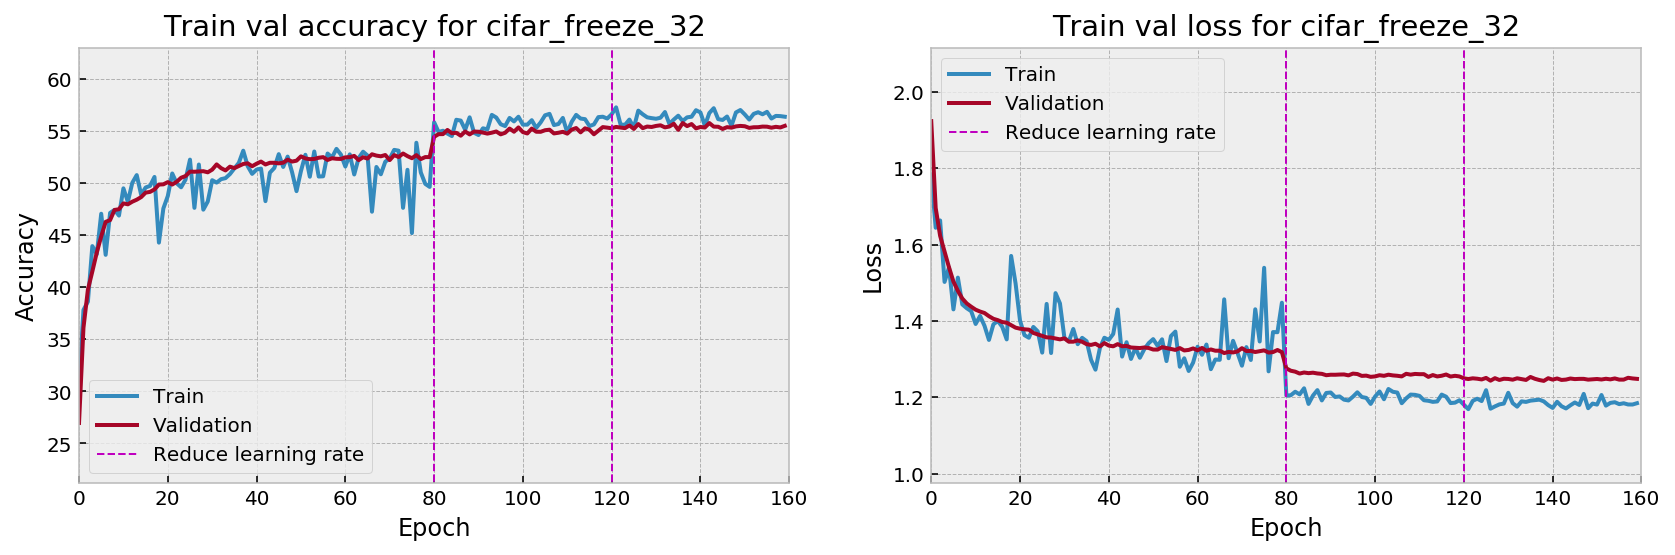

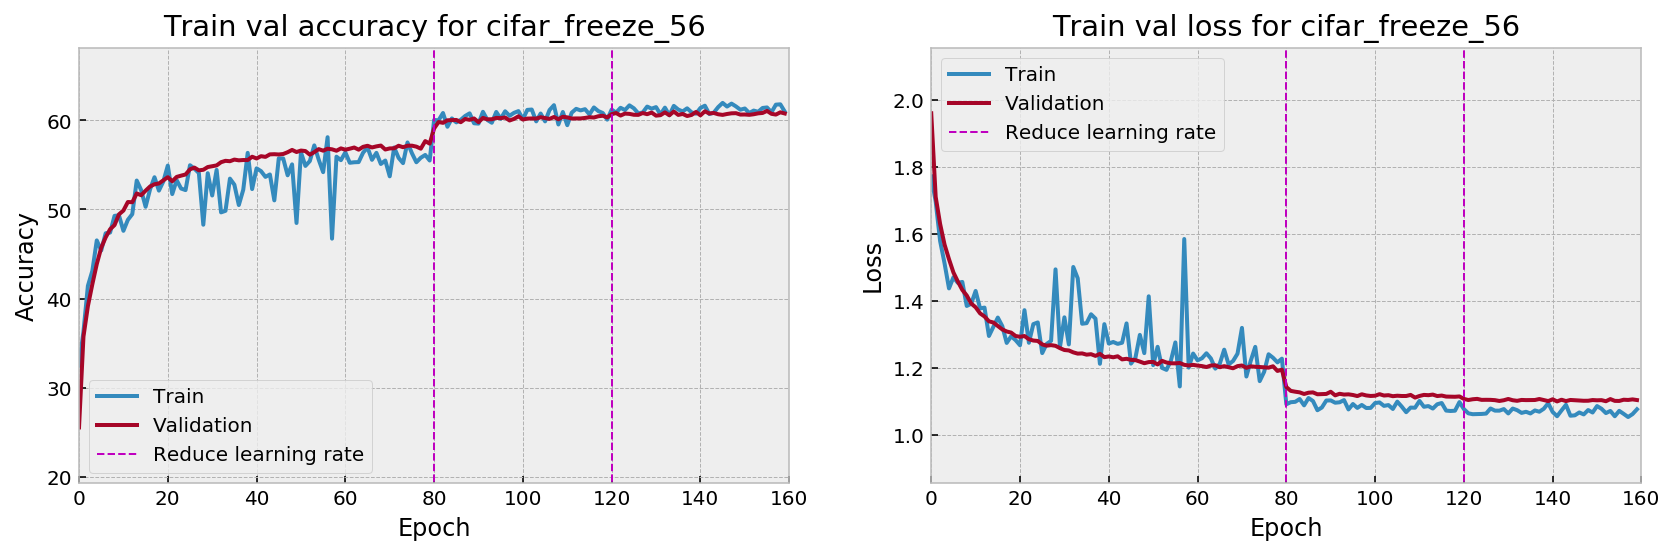

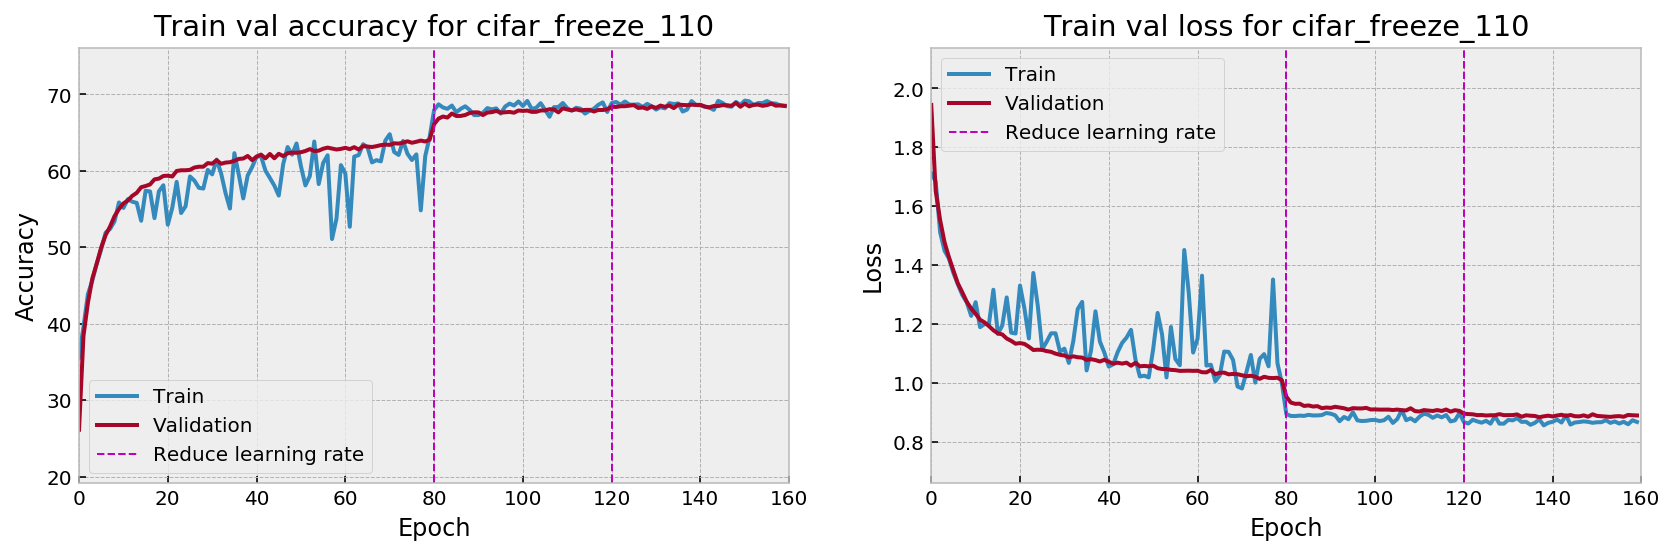

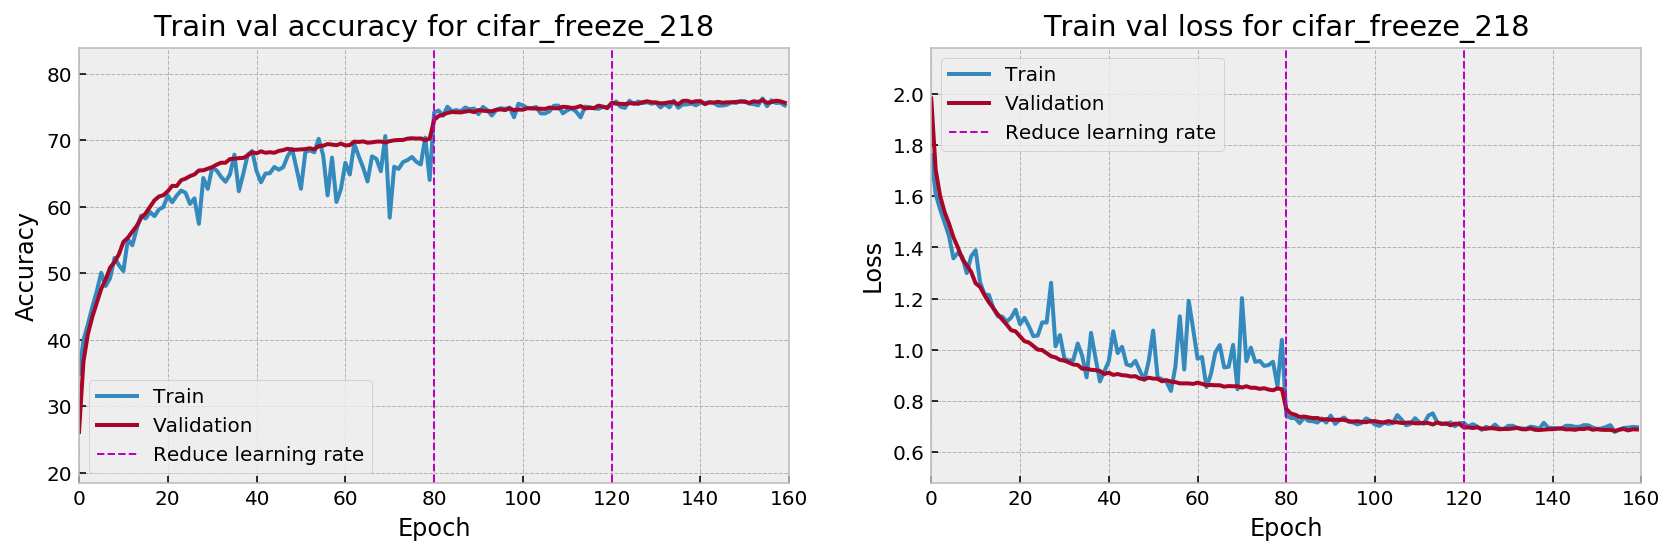

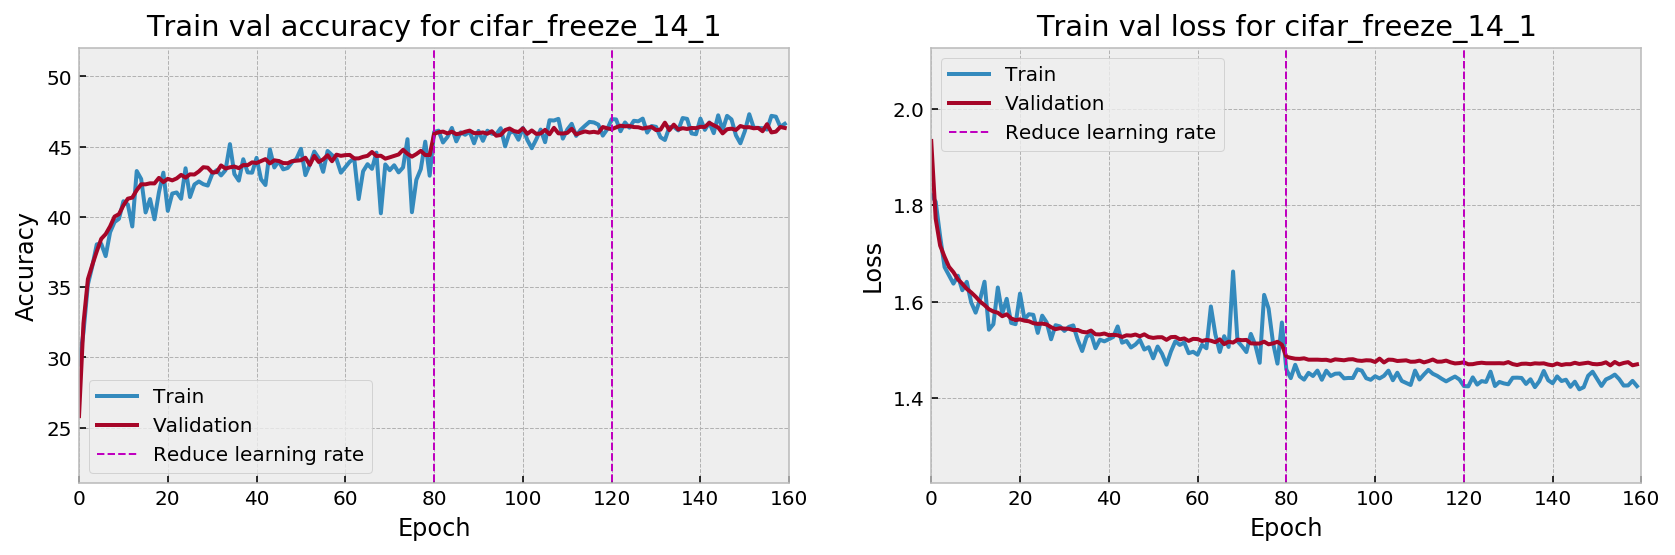

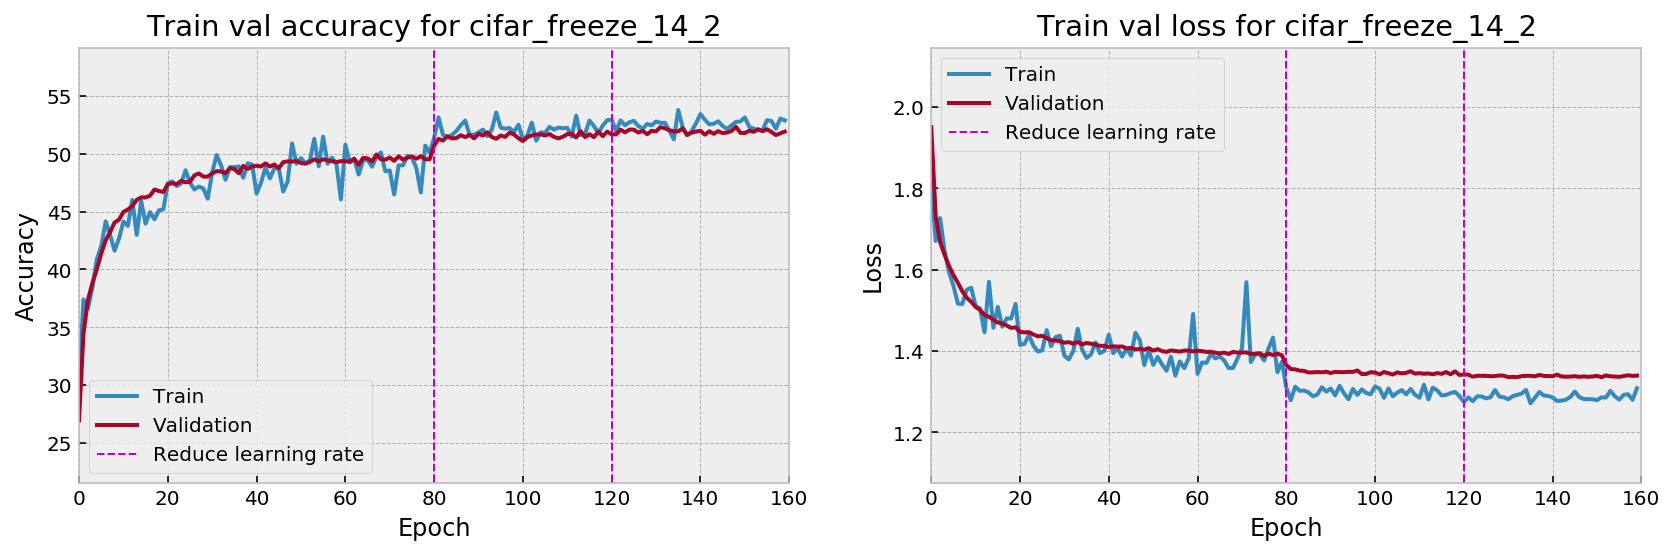

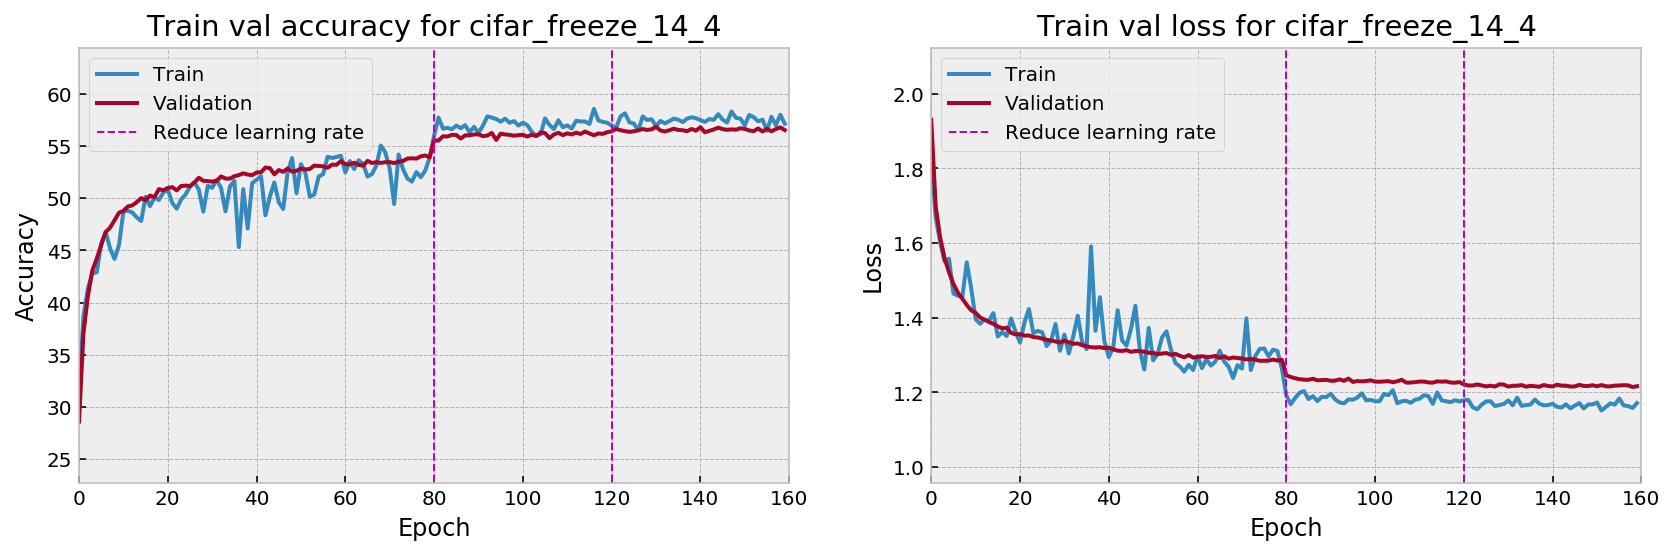

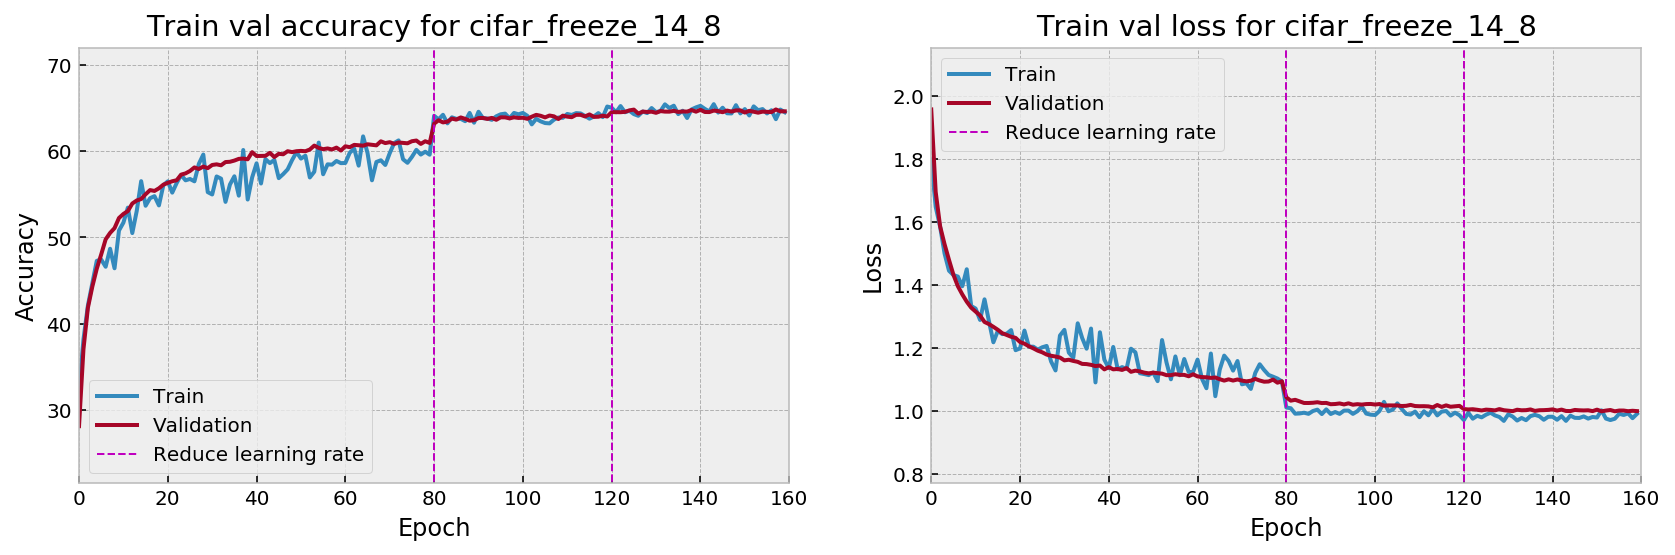

In [10]:
for name, metric, loss in zip(all_models, model_metric, model_loss):
    plot_train_val(name, metric, loss)

Заметим интересную особенность - для сетей в которых обучаются все параметры присутствует переобучение и почти все сети достигают 100% точности в конце тренировки. В то время ни одна сеть с замороженными весами не переобучилась и результат на тренировки в среднем совпадает с результатом на валидации. 

Это может быть связано с количеством обучаемых параметров например в сети resnet 110 обучается 1.7 млн параметров, а при заморозке только 8000 параметров BN. 

Авторы нашли 

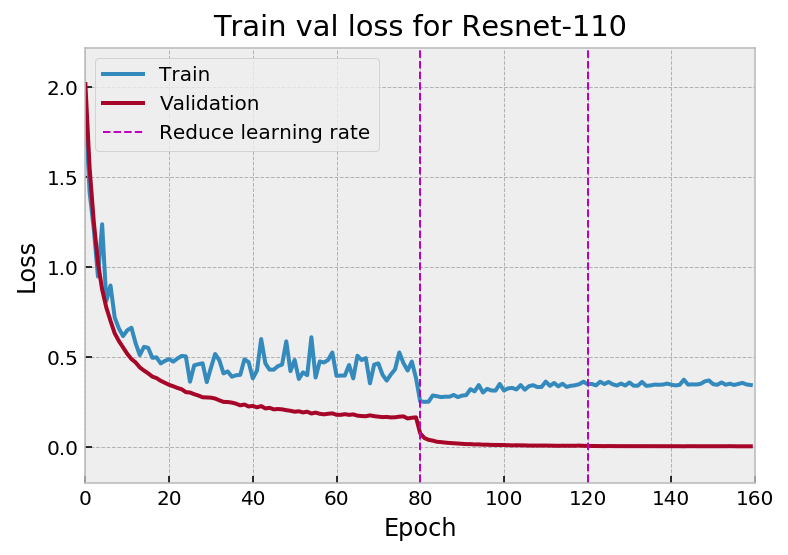

In [20]:
# plot loss
plot_train_val("Resnet-110", loss_110.values[:,1], loss_110.values[:,0], accuracy=False)

In [41]:
from matplotlib import pyplot as plt
import numpy as np

In [44]:
def plot_accuaracy(names, vals):
    """
    Function plot graph for accuracy .
    Params
    ------
    - name [str] : name of architecture for title.
    - train [list] : train loss or accuracy values.
    - val [list] : val loss or accuracy values.
    - accuracy [bool] : use for printing correct title and ylabel.
    """
    wide = {"name": [], "val": [], "label": []}
    deep = {"name": [], "val": [], "label": []}
    wide_name = []
    wide_val = []
    wide_label = []
    deep_name = []
    deep_val = []
    deep_label = []
    for name, val in zip(names, vals):
        name_split = name.split("_")
        if len(name_split) == 3:
            deep["name"].append(name_split[2])
            deep["val"].append(val)
            deep["label"].append(name_split[1])
        else:
            wide["name"].append("_".join(name_split[2:]))
            wide["val"].append(val)
            wide["label"].append(name_split[1])
            
    with plt.style.context('bmh'):
        assert(len(names) == len(vals))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
        fig.suptitle("Accuracy on varios architectures")
        ax1.set_title("Change deep")
        ax1.set_ylabel("Accuracy")
        ax1.set_xlabel("Network architecture")
        ax2.set_title("Change wide")
        ax2.set_ylabel("Accuracy")
        ax2.set_xlabel("Network architecture")
        
        # Plot train val data
        for arr, ax in zip([deep, wide],[ax1, ax2]):
            for label in set(arr["label"]):
                ns = []
                vs = []
                for v, n, l in zip(arr["val"], arr["name"], arr["label"]):
                    if l == label:
                        ns.append(n)
                        vs.append(v)
                ax.plot(ns, vs, label=label)
            ax.grid(True)
            ax.set_ylim(0, 100)
            major_ticks = np.arange(0, 100, 10)
            ax.set_yticks(major_ticks)

        ax.legend()

        plt.show()
